In [55]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments, pipeline
from datasets import load_dataset, DatasetDict, ClassLabel, Dataset
from huggingface_hub import login
import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from datasets import DatasetDict, concatenate_datasets
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

#### Load datasets and map labels to integers, "benign" -> 0, "jailbreak" -> 1

In [56]:
dataset = load_dataset("jackhhao/jailbreak-classification")
# rename prompt to text and label to label
dataset = dataset.rename_column("prompt", "text")
dataset = dataset.rename_column("type", "labels")

def label_mapping(example):
    example["labels"] = 0 if example["labels"] == "benign" else 1
    return example

dataset = dataset.map(label_mapping)

#### Show Dataset:

In [57]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1044
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 262
    })
})

#### Load pre-trained BERT tokenizer and model for binary sequence classification from Hugging Face, with the model configured for two output labels.

In [58]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Make train_df

In [59]:
train_df = dataset["train"].to_pandas()

#### Show the number of rows that contain text bigger than 512 tokens

In [60]:
train_df['num_of_tokens_text'] = train_df["text"].apply(lambda x: len(tokenizer(x)["input_ids"]))
num_of_rows_bigger_then_512 = len(train_df[train_df['num_of_tokens_text'] > 512])
print("Number of rows that have more than 512 tokens in text: ", num_of_rows_bigger_then_512)
print("Precentage of rows that have more than 512 tokens in text: ", np.round(num_of_rows_bigger_then_512 / len(train_df) * 100, 2), "%")


Token indices sequence length is longer than the specified maximum sequence length for this model (854 > 512). Running this sequence through the model will result in indexing errors


Number of rows that have more than 512 tokens in text:  192
Precentage of rows that have more than 512 tokens in text:  18.39 %


#### 18.4% is quite high. Let's preprocess the text to reduce the token count, and then drop the rows that have more than 512 tokens."

In [61]:
# Download stopwords if needed
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in stop_words)
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())
def preprocess_text(text):
    # Basic text cleaning
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # Lemmatize text
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

#### After preprocess the number is 17 and the precentage is 1.63%.

In [62]:
train_df['text_after_preprocess'] = train_df['text'].apply(preprocess_text)
train_df['num_of_tokens_text_after_preprocess'] = train_df["text_after_preprocess"].apply(lambda x: len(tokenizer(x)["input_ids"]))
num_of_rows_bigger_then_512_after_preprocess = len(train_df[train_df['num_of_tokens_text_after_preprocess'] > 512])
print("Number of rows that have more than 512 tokens in text after preprocess: ", num_of_rows_bigger_then_512_after_preprocess)
print("Precentage of rows that have more than 512 tokens in text after preprocess: ", np.round(num_of_rows_bigger_then_512_after_preprocess / len(train_df) * 100, 2), "%")

Number of rows that have more than 512 tokens in text after preprocess:  17
Precentage of rows that have more than 512 tokens in text after preprocess:  1.63 %


#### Show distribution of num_of_tokens_text and num_of_tokens_text_preprocess in 2 histograms

Text(0.5, 1.0, 'Number of tokens in preprocessed text')

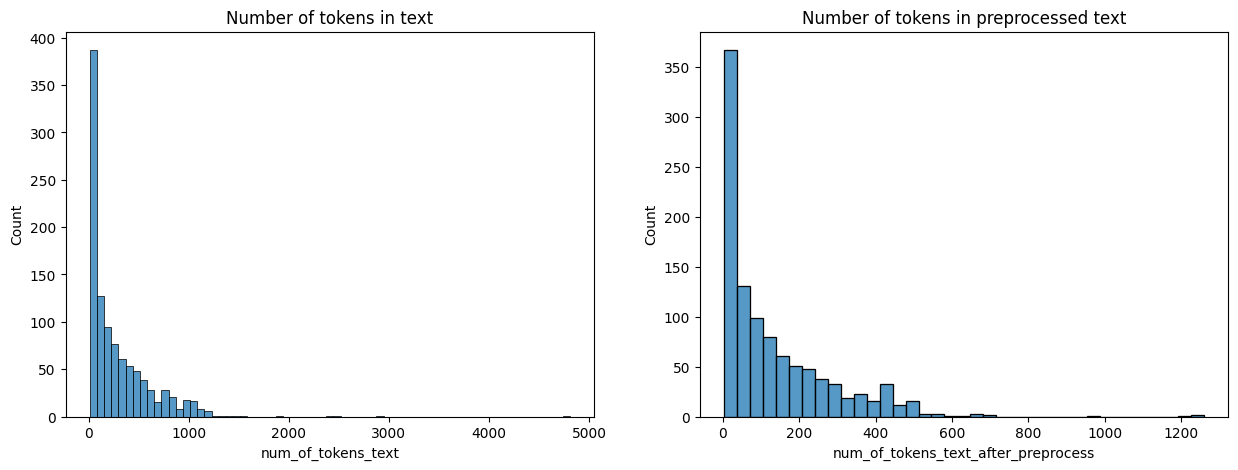

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(train_df['num_of_tokens_text'], ax=ax[0])
ax[0].set_title('Number of tokens in text')
sns.histplot(train_df['num_of_tokens_text_after_preprocess'], ax=ax[1])
ax[1].set_title('Number of tokens in preprocessed text')

#### Drop the rows that have more than 512 tokens in text after preprocess

In [64]:

# drop rows that have more than 512 tokens in text after preprocess
train_df = train_df[train_df['num_of_tokens_text'] <= 512]

#### Filter columns and reset index 

In [65]:
train_df = train_df[['text', 'labels']]
train_df = train_df.reset_index(drop=True)


#### Create dataset_2 with update train data

In [66]:

dataset_2 = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'test': dataset['test'],    
})


#### Show dataset_2

In [67]:
dataset_2

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 852
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 262
    })
})

#### Create a function to preprocess and tokenize the text

In [68]:
def tokenize_function_with_preprocess(examples):
    examples["text"] = [preprocess_text(text) for text in examples["text"]]
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset_2.map(tokenize_function_with_preprocess, batched=True)

Map: 100%|██████████| 852/852 [00:01<00:00, 681.88 examples/s]


#### Split the dataset into training and validation, and test sets. Make final_dataset.

In [69]:
tokenized_datasets = tokenized_datasets.cast_column('labels', ClassLabel(names=['benign', 'jailbreak']))  # Modify names as needed

# Split the training set into 80% train and 20% validation
train_test_split = tokenized_datasets['train'].train_test_split(test_size=0.2, stratify_by_column='labels', seed=42)

# Combine the new splits into a DatasetDict
final_dataset = DatasetDict({
    'train': train_test_split['train'],
    'val': train_test_split['test'],
    'test': tokenized_datasets['test']
})

Casting the dataset: 100%|██████████| 852/852 [00:00<00:00, 244061.40 examples/s]


#### Training 

In [70]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5, 
    lr_scheduler_type="linear",
    save_strategy="no",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["val"],

)
trainer.train()

/opt/anaconda3/envs/qualifier-env/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 86/430 [02:01<05:56,  1.04s/it]

{'eval_loss': 0.17831751704216003, 'eval_runtime': 7.6298, 'eval_samples_per_second': 22.412, 'eval_steps_per_second': 2.883, 'epoch': 1.0}


 40%|████      | 172/430 [04:03<04:33,  1.06s/it]

{'eval_loss': 0.07416871190071106, 'eval_runtime': 7.5531, 'eval_samples_per_second': 22.64, 'eval_steps_per_second': 2.913, 'epoch': 2.0}


 60%|██████    | 258/430 [06:05<02:59,  1.04s/it]

{'eval_loss': 0.3528507649898529, 'eval_runtime': 7.6144, 'eval_samples_per_second': 22.457, 'eval_steps_per_second': 2.889, 'epoch': 3.0}


 80%|████████  | 344/430 [08:05<01:28,  1.03s/it]

{'eval_loss': 0.20816081762313843, 'eval_runtime': 7.5926, 'eval_samples_per_second': 22.522, 'eval_steps_per_second': 2.898, 'epoch': 4.0}


100%|██████████| 430/430 [10:06<00:00,  1.41s/it]

{'eval_loss': 0.26743242144584656, 'eval_runtime': 7.6323, 'eval_samples_per_second': 22.405, 'eval_steps_per_second': 2.882, 'epoch': 5.0}
{'train_runtime': 606.2829, 'train_samples_per_second': 5.616, 'train_steps_per_second': 0.709, 'train_loss': 0.1306006498115007, 'epoch': 5.0}


TrainOutput(global_step=430, training_loss=0.1306006498115007, metrics={'train_runtime': 606.2829, 'train_samples_per_second': 5.616, 'train_steps_per_second': 0.709, 'total_flos': 895893143500800.0, 'train_loss': 0.1306006498115007, 'epoch': 5.0})

##### evaluate the model

In [71]:
trainer_evaluate = trainer.evaluate()
print("trainer_evaluate:", trainer_evaluate)

100%|██████████| 22/22 [00:07<00:00,  2.91it/s]

trainer_evaluate: {'eval_loss': 0.26743242144584656, 'eval_runtime': 7.6221, 'eval_samples_per_second': 22.435, 'eval_steps_per_second': 2.886, 'epoch': 5.0}


#### Update id2label and label2id

In [72]:
trained_model = trainer.model
trained_model.config.id2label = {
    0: "benign",
    1: "jailbreak"
}
trained_model.config.label2id = {
    "benign": 0,
    "jailbreak": 1
}

#### test_prompts is a list of all test prompts

In [73]:
test_prompts = final_dataset["test"]["text"]

#### The function predict_long_text_with_preprocess processes a list of texts by first preprocessing and tokenizing each text. It splits long texts into chunks (512 tokens with 100 tokens overlap), classifies each chunk using a model, and checks if any chunk is classified as "jailbreak." The final classification for each text is determined by whether any chunk contains "jailbreak". The overlapping happens to maintain the connection between the different parts of the text. It then returns a list of predictions ("jailbreak" or "benign") for each text. The model is run on the available device (MPS or CPU).

![Sliding Window Overlapping](images/sliding_window_overlaping.png)







In [74]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)

def predict_long_text_with_preprocess(texts, model, tokenizer):
    predictions = []
    
    for text in texts:
        # Preprocess and tokenize the text into chunks
        text = preprocess_text(text)
        inputs = tokenizer(text, return_tensors="pt", truncation=False)
        input_ids = inputs["input_ids"].squeeze()

        # Define chunk size and overlap
        chunk_size = 512
        overlap_size = 100

        # Create chunks with overlap
        chunks = []
        for i in range(0, len(input_ids), chunk_size - overlap_size):
            chunk = input_ids[i:i + chunk_size]
            chunks.append(chunk)

        # Flag to track if any chunk is classified as "jailbreak"
        contains_jailbreak = False
        for chunk in chunks:
            chunk = chunk.unsqueeze(0).to(device)  # Move chunk to the correct device (MPS or CPU)

            # Predict on the chunk
            with torch.no_grad():
                outputs = model(chunk)
                logits = outputs.logits
                prediction = torch.argmax(logits, dim=1).item()

                # Check if this chunk is classified as "jailbreak"
                if model.config.id2label[prediction] == "jailbreak":
                    contains_jailbreak = True
                    break  # Stop further checks if "jailbreak" is detected

        # Final decision based on whether any chunk was classified as "jailbreak"
        final_prediction = "jailbreak" if contains_jailbreak else "benign"
        predictions.append(final_prediction)
    
    return predictions


#### Make y_test

In [75]:
y_test = final_dataset["test"]["labels"]

#### Predict on the test set

In [76]:
# lets do on test set
y_pred = predict_long_text_with_preprocess(test_prompts, trained_model, tokenizer)
y_pred = [0 if x == "benign" else 1 for x in y_pred]

#### Show metrics

In [77]:
# Move y_pred to CPU and convert to NumPy
y_pred_cpu = y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else np.array(y_pred)

# Calculate metrics
_f1_score = f1_score(y_test, y_pred_cpu)
_accuracy = accuracy_score(y_test, y_pred_cpu)
_recall = recall_score(y_test, y_pred_cpu)
_precision = precision_score(y_test, y_pred_cpu)

# Print results
print(f"F1 Score: {_f1_score:.4f}")
print(f"Accuracy: {_accuracy:.4f}")
print(f"Recall: {_recall:.4f}")
print(f"Precision: {_precision:.4f}")

F1 Score: 0.9753
Accuracy: 0.9733
Recall: 0.9928
Precision: 0.9583


#### Show confusion matrix

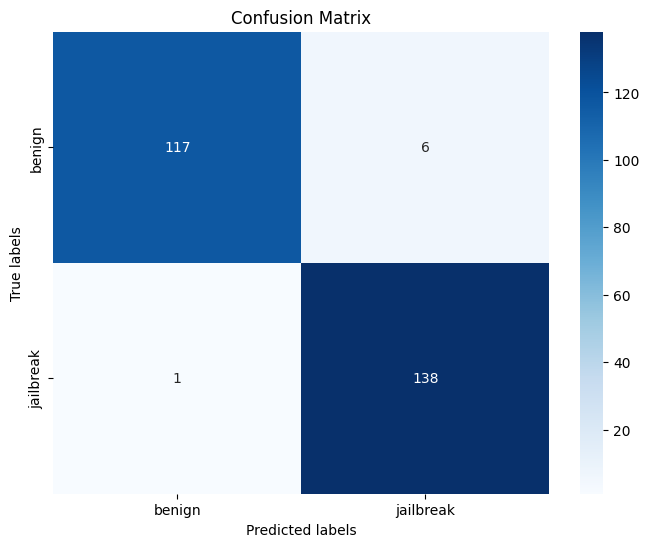

In [78]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred_cpu, labels=['benign', 'jailbreak'])

#### Make test_df

In [79]:
test_df = final_dataset["test"].to_pandas()

#### Make ten_longest_prompt_from_test_bengin and ten_longest_prompt_from_test_jailbreak

In [80]:
ten_longest_prompt_from_test_bengin = test_df[test_df["labels"] == 0].sort_values("text", key=lambda x: x.str.len(), ascending=False).head(10)['text'].values
ten_longest_prompt_from_test_jailbreak = test_df[test_df["labels"] == 1].sort_values("text", key=lambda x: x.str.len(), ascending=False).head(10)['text'].values

#### Predict them:

In [81]:
predict_long_text_with_preprocess(ten_longest_prompt_from_test_bengin, trained_model, tokenizer)

['benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign']

In [82]:
predict_long_text_with_preprocess(ten_longest_prompt_from_test_jailbreak, trained_model, tokenizer)

['jailbreak',
 'jailbreak',
 'jailbreak',
 'jailbreak',
 'jailbreak',
 'jailbreak',
 'jailbreak',
 'jailbreak',
 'jailbreak',
 'jailbreak']

#### Upload model, tokenizer and preprocessing.py to huggingface hub

In [83]:
# Load environment variables (ensure HF_TOKEN is in your .env file)
load_dotenv()
from huggingface_hub import upload_file

# Check if the HF_TOKEN is present and log in
if 'HF_TOKEN' in os.environ:
    print("Pushing to Hugging Face Hub")
    HF_TOKEN = os.getenv("HF_TOKEN")
    login(token=HF_TOKEN)

    # Path to your local preprocessing.py
    local_file = "preprocessing.py"
    model_name = "oranne55/qualifier-model4-finetune-pretrained-transformer-for-long-inputs"

    # Push to the existing repo
    upload_file(
    path_or_fileobj=local_file,
    path_in_repo=local_file,  # Ensure the correct path in the repository
    repo_id=model_name,  # Your repo ID
    token=HF_TOKEN  # Make sure the token has push rights to the repo
)


    # Upload model and tokenizer to the hub
    trained_model.push_to_hub(model_name)
    tokenizer.push_to_hub(model_name)



    # Now push preprocessing.py to Hugging Face Hub


    print("Files pushed to Hugging Face Hub successfully.")

Pushing to Hugging Face Hub


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
No files have been modified since last commit. Skipping to prevent empty commit.
model.safetensors: 100%|██████████| 438M/438M [00:50<00:00, 8.71MB/s] 
No files have been modified since last commit. Skipping to prevent empty commit.


Files pushed to Hugging Face Hub successfully.
